<a href="https://colab.research.google.com/github/andrew-veriga/Tensorflow-labs/blob/master/TimeSeriesIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Этот блокнот содержит код для лекции с небольшими дополнениями

# Setup
Начнем с запуска ячеек, содержащих импорт...

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Тренд и сезонность
... а также несколько вспомогательных функций.

Одна выводит графики рядов

In [0]:

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

а другая возвращает тренд

In [0]:
def trend(time, slope=0):
    return slope * time

Давайте создадим временные ряды, которые имеют **восходящий тренд**, или, другими словами, тенденцию к возрастанию:

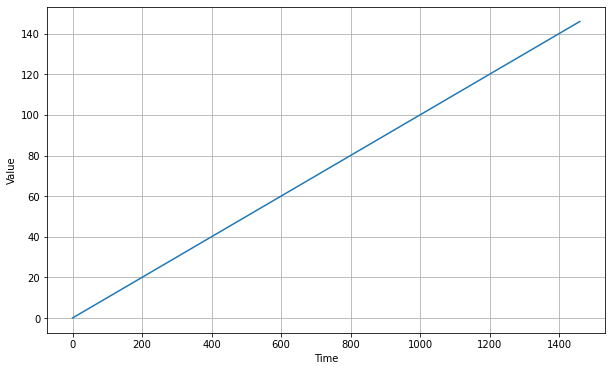

In [4]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Хотя это прямая линия, это также пример временного ряда. Здесь ось x - это время, а y - значение функции на этом шаге времени.

 
Теперь давайте сгенерируем временной ряд с сезонным паттерном. 
Первая функция задает сезонный шаблон, а вторая использует этот шаблон для генерации временного ряда с **сезонностью**.

In [0]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

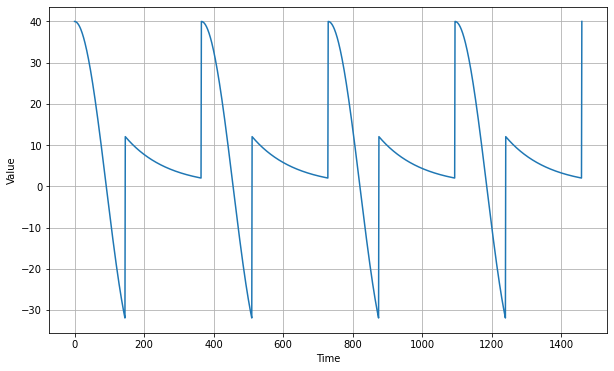

In [6]:
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Здесь хорошо видны четкие пики и впадины. Но в дополнение к ним, есть другие регулярные всплески, или, как их принято называть в сериях - **спайки**. Это можно рассматривать как грубое моделирование сезонных изменений. Например, может быть, прибыль для магазина будет отрицательной в тот день, когда магазин закрыт, немного увеличиваясь на следующий день, падая в течение недели, а затем снова показывать спайк в выходной день. 

Что если мы добавим к этому тренд, чтобы сезонные данные, продолжая следовать этой схеме, со временем увеличивались? Возможно, этот тренд имитирует растущий бизнес, поэтому, построив его, мы увидим ту же модель, но с общим восходящим трендом.

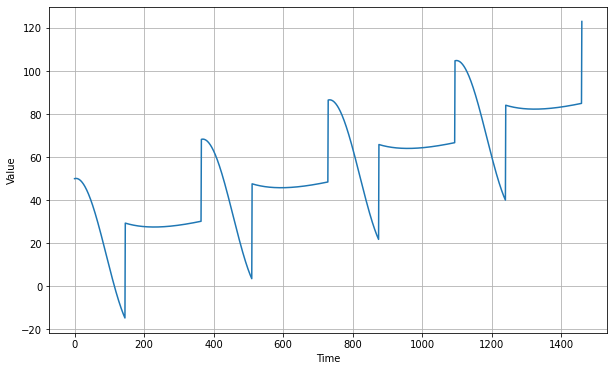

In [7]:
baseline = 10
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Добавим еще одну особенность, которая часто встречается во временных рядах:

# Шум

На практике мало какие реальные временные ряды имеют такой чистый сигнал. Они обычно имеют некоторый шум, и отношение сигнал / шум иногда может быть очень низким. Давайте сгенерируем белый шум:

Вот функция, которая добавляет некоторый шум в ряд:

In [0]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

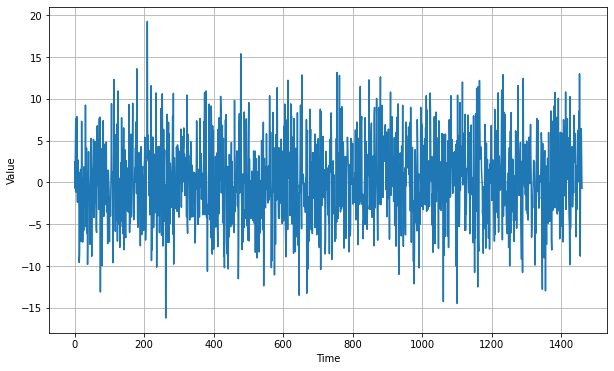

In [9]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

сложим почленно наш временной ряд с полученным массивом белого шума, и получаем очень шумный ряд той же сезонности.

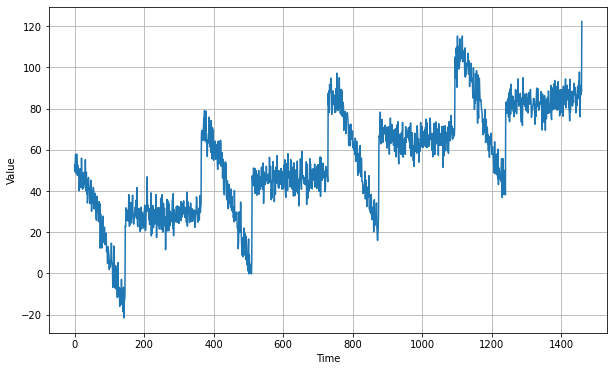

In [10]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Хорошо, пока он выглядит достаточно реалистично. 
Это интересно, потому что в этот момент человеческий глаз может пропустить много сезонных данных, но, надеюсь, компьютер сможет их обнаружить.


#Автокорелляция

Далее мы немного поговорим о автокорреляции, и сначала приведем пару функций:
Это две разные функции автокорреляции, и выведем графики обеих, чтобы увидеть эффекты каждой из них.

In [0]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

И здесь мы добавляем автокорреляцию в серию и строим ее.

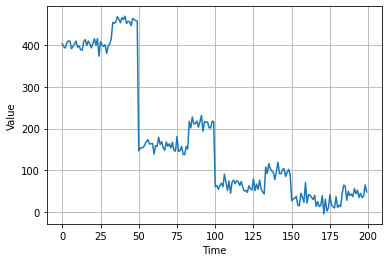

In [12]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

Эта автокорелляция особенно интересна, потому что тут можно увидеть один и тот же паттерн, повторяющийся в разных масштабах. То есть некий рисунок, затем резкое падение, потом тот же самый рисунок в меньшем масштабе с тем же самым падением, которое затем сокращается и т.д.

Изменим автокорреляцию и снова запустим ее, мы увидим другую функцию.

In [0]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

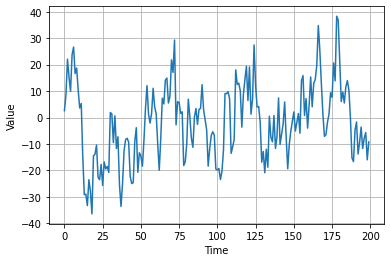

In [14]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

Теперь добавим сезонные колебания и тренд:

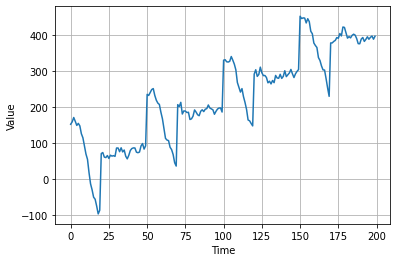

In [15]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

#Нестационарный временной ряд

Теперь давайте сложим их, чтобы имитировать сезонные временные ряды и событие  которое все меняет. Например, это может быть финансовый ряд, показывающий сезонность, но затем что-то меняется, например, провал бизнеса или какие-то большие новости.

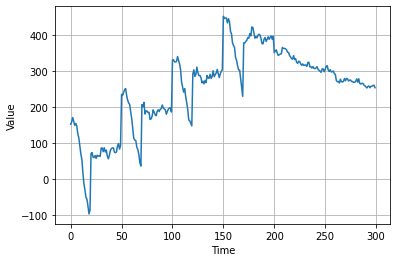

In [16]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
#series += noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

#Импульсы

Теперь добавим некоторые импульсы и построим их. Ничего особенного здесь пока нет.

In [0]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

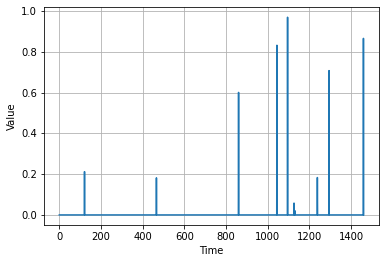

In [18]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

Но если добавить некоторые автокорреляции к этим импульсам,  мы увидим некоторые поведения, которые мы обсуждали ранее, когда после импульса происходит затухание, но затухание может быть прервано другим импульсом.

In [0]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar

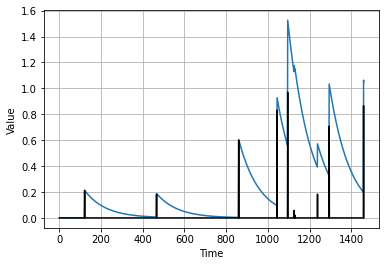

In [20]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

Это затухание может быть автокоррелировано так, что после импульса оно затухает, но затем затухание автокоррелирует. Итак, у нас есть такие убывающие кривые:

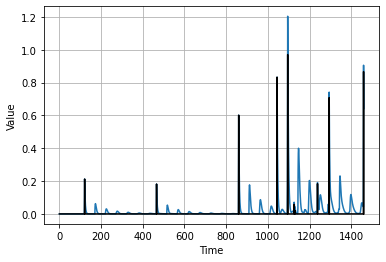

In [21]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

Надеемся, что это исследование некоторых синтетических данных, показавшее некоторые атрибуты временных рядов, помогло вам понять некоторые термины. Нодобные синтетические данные очень полезны, если вы хотите научиться использовать машинное обучение для понимания и прогнозирования данных. На следующем уроке вы сделаете первые шаги к прогнозированию следующих значений в синтетической серии, а затем начнете применять полученные знания к реальным данным.

Не теряйте этот ноутбук, отсюда всегда можно будет скопировать некоторые полезные приемы. Полезно будет пройти его еще раз и поиграть с цифрами, чтобы увидеть, как отражаются эти изменения на графиках.

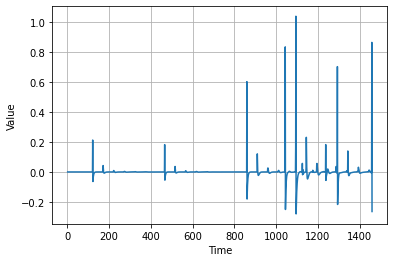

In [22]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

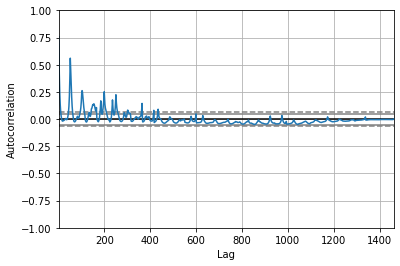

In [23]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [24]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.428
Method:                       css-mle   S.D. of innovations              0.053
Date:                Mon, 06 Apr 2020   AIC                          -4432.855
Time:                        09:39:49   BIC                          -4395.852
Sample:                             1   HQIC                         -4419.052
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.384      0.701      -0.001       0.002
ar.L1.D.y     -0.1235      0.026     -4.714      0.000      -0.175      -0.072
ar.L2.D.y     -0.1254      0.029     -4.333      0.0

In [25]:
import pandas as pd

df = pd.read_csv("https://github.com/andrew-veriga/Tensorflow-labs/raw/master/sunspots.csv", parse_dates=["Date"], index_col="Date")
series = df["Monthly Mean Total Sunspot Number"].asfreq("1M")
series.head()

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
Freq: M, Name: Monthly Mean Total Sunspot Number, dtype: float64

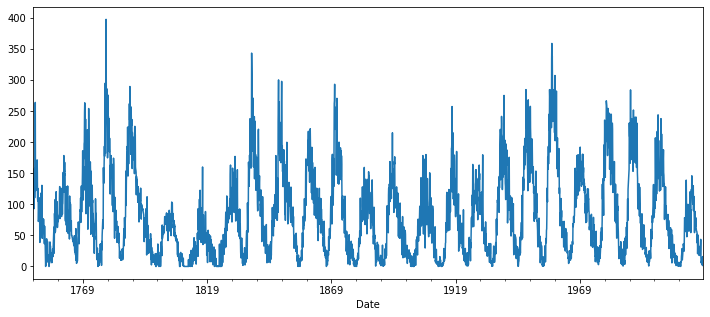

In [26]:
series.plot(figsize=(12, 5))

Это данные о пятнах на солнце, и мы поговорим об этом больше в 4-м модуле.

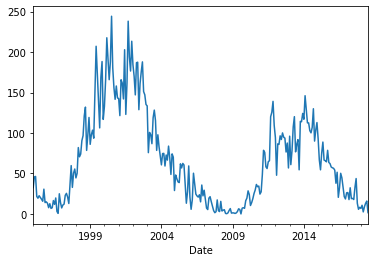

In [27]:
series["1995-01-01":].plot()

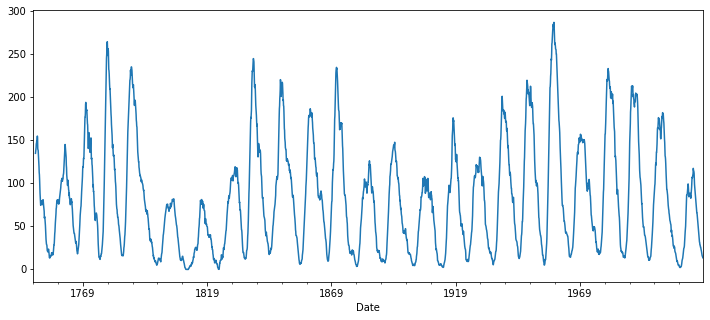

In [28]:
series.rolling(12).mean().plot(figsize=(12, 5))

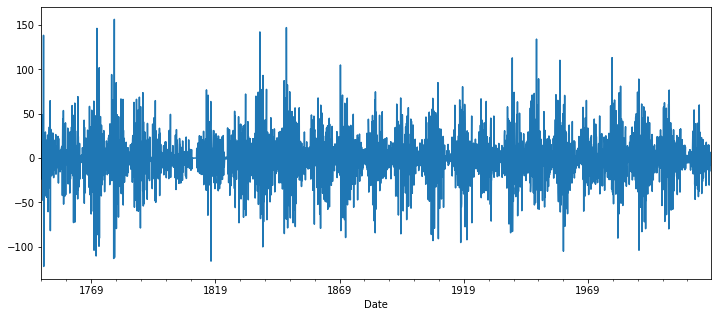

In [29]:
series.diff(1).plot(figsize=(12, 5))
#plt.axis([0, 100, -50, 50])

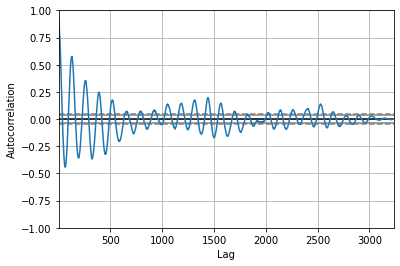

In [30]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

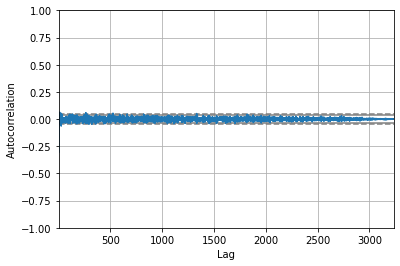

In [31]:
autocorrelation_plot(series.diff(1)[1:])

(0.0, 500.0, -0.1, 0.1)

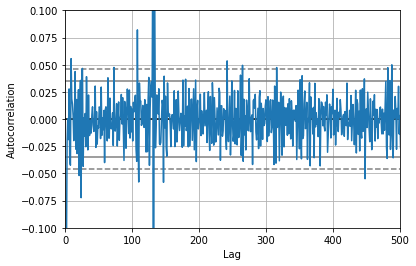

In [32]:
autocorrelation_plot(series.diff(1)[1:].diff(11 * 12)[11*12+1:])
plt.axis([0, 500, -0.1, 0.1])

(0.0, 50.0, -0.1, 0.1)

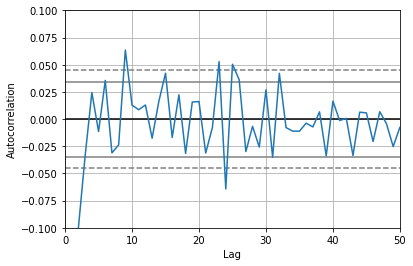

In [33]:
autocorrelation_plot(series.diff(1)[1:])
plt.axis([0, 50, -0.1, 0.1])

In [34]:
116.7 - 104.3

12.400000000000006

In [35]:
[series.autocorr(lag) for lag in range(1, 50)]

[0.9173241872367174,
 0.8847544206843755,
 0.868599123137202,
 0.8579945644357173,
 0.8433856340533112,
 0.8306731729540908,
 0.8121138897370149,
 0.7986059878541056,
 0.7890399489112041,
 0.7689560950230403,
 0.7474788716472306,
 0.7238791854325145,
 0.6980482665379879,
 0.6751408790165827,
 0.6495670049994807,
 0.6170092179855494,
 0.5872028494447984,
 0.5537209387574675,
 0.5254318210710769,
 0.49453915657274083,
 0.4609225001523783,
 0.4325062022560218,
 0.4054329883610248,
 0.36959289593532285,
 0.3443549899460771,
 0.3106967622634346,
 0.2711411693399097,
 0.23646964014948227,
 0.20297806535027266,
 0.17379537689762675,
 0.14010793836897956,
 0.11227445177460688,
 0.07751076852866026,
 0.044054957960606746,
 0.012510863120931944,
 -0.017282156504566333,
 -0.046433352357512225,
 -0.07440203532677167,
 -0.10339501296715731,
 -0.12680806162977237,
 -0.1530928264197593,
 -0.17906178224521474,
 -0.20506772757843425,
 -0.22530867957591932,
 -0.2466587000579558,
 -0.26904607854968615,
 

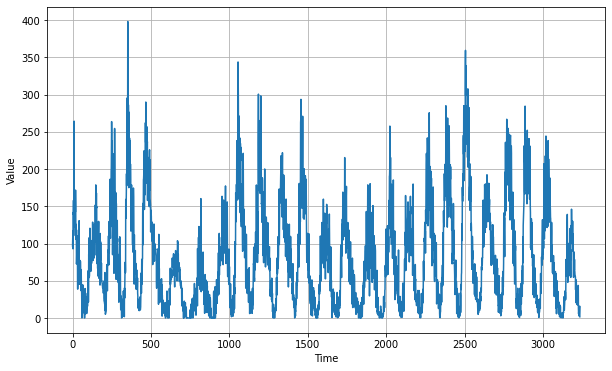

In [42]:
# Read a comma-separated values (csv) file into DataFrame.
import csv
time_step = []
sunspots = []
import urllib
urllib.request.urlretrieve('https://github.com/andrew-veriga/Tensorflow-labs/raw/master/sunspots.csv', '/tmp/sunspots.csv')

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

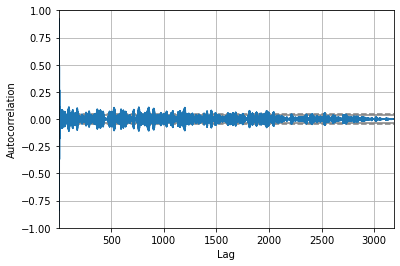

In [43]:
from pandas.plotting import autocorrelation_plot

series_diff = series
for lag in range(50):
  series_diff = series_diff[1:] - series_diff[:-1]

autocorrelation_plot(series_diff)

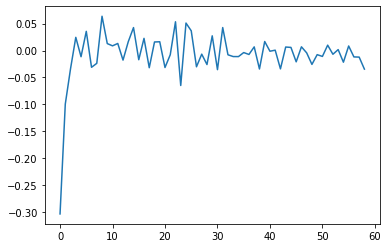

In [44]:
import pandas as pd

series_diff1 = pd.Series(series[1:] - series[:-1])
autocorrs = [series_diff1.autocorr(lag) for lag in range(1, 60)]
plt.plot(autocorrs)
plt.show()